In [1]:
#!pip install pymorphy2

In [2]:
# !pip install mlflow

In [3]:
# !pip install transformers

# Project description: NLP task with RuBERT and LoRA for RuCoLa
In this project the goal was to fine-tune the RuBERT model for the RuCoLa task, a binary classification task predicting cognitive load in Russian texts. The model was evaluated using accuracy and MCC metrics. Additionally, LoRA was applied to the model to optimize training and reduce the number of trainable parameters.


###Input:

in_domain_train.csv: Training dataset with labeled text samples.

in_domain_dev.csv: Evaluation dataset for testing the model's performance.

###Output:

The model predicts the cognitive load class for each text.

###Approach:

Fine-tuning the RuBERT model using the DeepPavlov/rubert-base-cased version, augmented with LoRA for parameter efficiency. LoRA was used to reduce the number of trainable parameters by applying low-rank updates to certain layers.

##Model Description.
The model utilized:

RuBERT: Pretrained BERT model for the Russian language.

LoRA: A technique applied to reduce training time and model size by applying low-rank updates to the attention layers. The LoraConfig was configured with r=16, lora_alpha=32, and lora_dropout=0.2.

###Steps:

1) Data Preprocessing: text was cleaned, lemmatized, and augmented using synonym replacement. Additional features like sentence length and punctuation count were also generated.

2) LoRA Integration: LoRA was applied to the pretrained RuBERT model to make the training process more efficient by adapting low-rank matrices in specific transformer layers. This resulted in a more compact model with fewer trainable parameters.

3) Training: the model was trained with class weights to handle class imbalance and used a weighted CrossEntropyLoss. A learning rate scheduler was implemented for optimal training performance.

##Data Analysis
Basic statistics were calculated, including class distribution, average sentence length, and the number of unique words in the dataset.

##Model Training
The model was fine-tuned with LoRA, and training was conducted for 60 epochs using CrossEntropyLoss with class weights. The model was deployed on a GPU for faster computation. During training, model were logged for each epoch.

##Results
The model was evaluated on in_domain_dev.csv using accuracy and MCC. LoRA helped achieve efficient training while maintaining high performance.

##Model logging with MLflow

The model was logged for each epoch.

Also at the end of the project model performance and configuration were logged using MLflow.

This included:

Logging LoRA configuration parameters.

Recording key model metrics such as accuracy and MCC.



To complete the task, I used code examples from the [BERT Fine-Tuning Tutorial with PyTorch](https://mccormickml.com/2019/07/22/BERT-fine-tuning/) article

## 1. Data analysis


### 1.1  Downloading the data

In [4]:
import torch

if torch.cuda.is_available():

    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Loading the data
train_data = pd.read_csv('in_domain_train.csv')
dev_data = pd.read_csv('in_domain_dev.csv')

train_data.head()

,id,sentence,acceptable,error_type,detailed_source
0,0,"Вдруг решетка беззвучно поехала в сторону, и н...",1,0,Paducheva2004
1,1,Этим летом не никуда ездили.,0,Syntax,Rusgram
2,2,Только Иван выразил какую бы то ни было готовн...,1,0,Paducheva2013
3,3,"Теперь ты видишь собственными глазами, как тут...",1,0,Paducheva2010
4,4,На поверку вся теория оказалась полной чепухой.,1,0,Paducheva2010


In [6]:
dev_data.head()

,id,sentence,acceptable,error_type,detailed_source
0,0,Иван вчера не позвонил.,1,0,Paducheva2013
1,1,"У многих туристов, кто посещают Кемер весной, ...",0,Syntax,USE8
2,2,Лесные запахи набегали волнами; в них смешалос...,1,0,USE5
3,3,Вчера президент имел неофициальную беседу с ан...,1,0,Seliverstova
4,4,Коллега так и не признал вину за катастрофу пе...,1,0,Testelets


Let's calculate basic statistics

In [7]:
# Example count
num_examples_train = len(train_data)

# Class distribution
class_distribution_train = train_data['acceptable'].value_counts()

# Mean sentence length
mean_sentence_length_train = train_data['sentence'].apply(lambda x: len(x.split())).mean()

# Number of unique words
unique_words_train = set(word for sentence in train_data['sentence'] for word in sentence.split())
num_unique_words_train = len(unique_words_train)

print(f"Number of examples in train data: {num_examples_train}")
print(f"Class distribution in train data:\n{class_distribution_train}")
print(f"Mean sentence length in train data: {mean_sentence_length_train}")
print(f"Number of unique words in train data: {num_unique_words_train}")

Number of examples in train data: 7869
Class distribution in train data:
acceptable
1    5864
0    2005
Name: count, dtype: int64
Mean sentence length in train data: 8.55648748252637
Number of unique words in train data: 23014


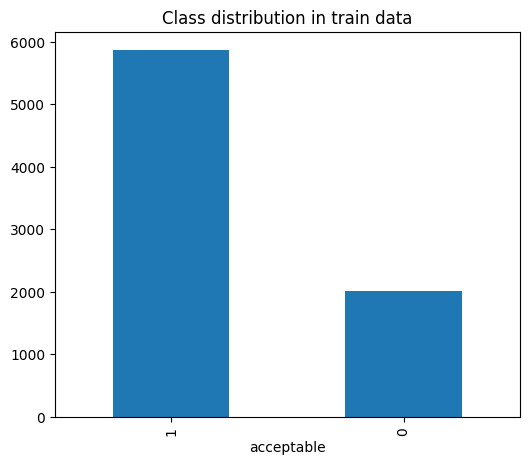

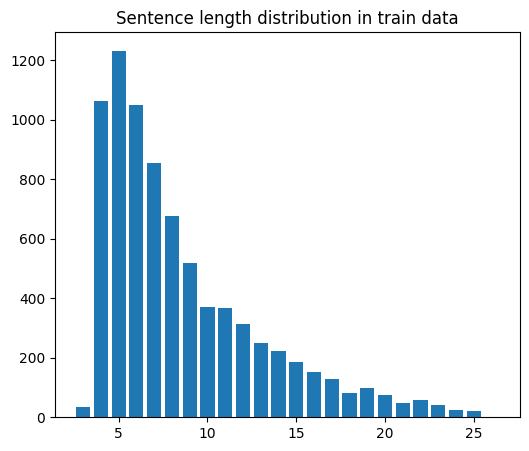

In [8]:
# Visualization

import matplotlib.pyplot as plt

# Class distribution
fig, ax = plt.subplots(figsize=(6, 5))
class_distribution_train.plot(kind='bar', ax=ax, title='Class distribution in train data')
plt.show()

# Sentence length distribution
sentence_lengths_train = train_data['sentence'].apply(lambda x: len(x.split()))

min_length = sentence_lengths_train.min()
max_length = sentence_lengths_train.max()

fig, ax = plt.subplots(figsize=(6, 5))
bins = range(min_length, max_length + 2)
ax.hist(sentence_lengths_train, bins=bins, align='left', rwidth=0.8)
ax.set_title('Sentence length distribution in train data')
plt.show()

### 1.2 Splitting the data from `in_domain_train.csv` into train and val (`val_size = 10%`).

In [9]:
# Splitting the training data into training and validation sets
train_df, val_df = train_test_split(train_data, test_size=0.1, random_state=42, stratify=train_data['acceptable'])

print(f"Number of examples in the new training set: {len(train_df)}")
print(f"Number of examples in the validation set: {len(val_df)}")

Number of examples in the new training set: 7082
Number of examples in the validation set: 787


Perform additional preprocessing

In [10]:
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')

stop_words = set(stopwords.words('russian'))  # If the text is in Russian

def preprocess_text(sentence):
    # Removing punctuation and convert to lowercase
    sentence = re.sub(r'[^\w\s]', '', sentence.lower())
    # Tokenization
    tokens = word_tokenize(sentence)
    # Removing stop-words
    tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(tokens)

train_data['cleaned_sentence'] = train_data['sentence'].apply(preprocess_text)
dev_data['cleaned_sentence'] = dev_data['sentence'].apply(preprocess_text)

print(train_data[['sentence', 'cleaned_sentence']].head())


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


                                            sentence  \
0  Вдруг решетка беззвучно поехала в сторону, и н...   
1                       Этим летом не никуда ездили.   
2  Только Иван выразил какую бы то ни было готовн...   
3  Теперь ты видишь собственными глазами, как тут...   
4    На поверку вся теория оказалась полной чепухой.   

                                    cleaned_sentence  
0  решетка беззвучно поехала сторону балконе возн...  
1                           этим летом никуда ездили  
2               иван выразил какую готовность помочь  
3                        видишь собственными глазами  
4        поверку вся теория оказалась полной чепухой  


In [11]:
import pymorphy2
morph = pymorphy2.MorphAnalyzer()

def lemmatize_text(sentence):
    # Tokenizing the sentence into words
    tokens = word_tokenize(sentence)
    # Lemmatizing each token (convert it to its base form)
    lemmatized_tokens = [morph.parse(word)[0].normal_form for word in tokens]
    return ' '.join(lemmatized_tokens)

train_data['lemmatized_sentence'] = train_data['cleaned_sentence'].apply(lemmatize_text)
dev_data['lemmatized_sentence'] = dev_data['cleaned_sentence'].apply(lemmatize_text)

print(train_data[['cleaned_sentence', 'lemmatized_sentence']].head())



                                    cleaned_sentence  \
0  решетка беззвучно поехала сторону балконе возн...   
1                           этим летом никуда ездили   
2               иван выразил какую готовность помочь   
3                        видишь собственными глазами   
4        поверку вся теория оказалась полной чепухой   

                                 lemmatized_sentence  
0  решётка беззвучно поехать сторона балкон возни...  
1                             это лето никуда ездить  
2              иван выразить какой готовность помочь  
3                            видеть собственный глаз  
4        поверка весь теория оказаться полный чепуха  


In [12]:
# Generating additional features
def generate_features(df):
    df['sentence_length'] = df['sentence'].apply(lambda x: len(x.split()))
    df['unique_word_ratio'] = df['sentence'].apply(lambda x: len(set(x.split())) / len(x.split()))
    df['punctuation_count'] = df['sentence'].apply(lambda x: sum(1 for char in x if char in '.,!?'))
    return df

train_data = generate_features(train_data)
dev_data = generate_features(dev_data)

print(train_data[['sentence_length', 'unique_word_ratio', 'punctuation_count']].head())


   sentence_length  unique_word_ratio  punctuation_count
0               20               0.95                  4
1                5               1.00                  1
2               10               1.00                  1
3                8               1.00                  2
4                7               1.00                  1


In [13]:
# Replacing the word with synonym
from nltk.corpus import wordnet

def synonym_replacement(sentence):
    words = word_tokenize(sentence)
    new_sentence = []
    for word in words:
        synonyms = wordnet.synsets(word)
        if synonyms:
            synonym = synonyms[0].lemmas()[0].name()
            new_sentence.append(synonym)
        else:
            new_sentence.append(word)
    return ' '.join(new_sentence)

train_data['augmented_sentence'] = train_data['lemmatized_sentence'].apply(synonym_replacement)
print(train_data[['lemmatized_sentence', 'augmented_sentence']].head())


                                 lemmatized_sentence  \
0  решётка беззвучно поехать сторона балкон возни...   
1                             это лето никуда ездить   
2              иван выразить какой готовность помочь   
3                            видеть собственный глаз   
4        поверка весь теория оказаться полный чепуха   

                                  augmented_sentence  
0  решётка беззвучно поехать сторона балкон возни...  
1                             это лето никуда ездить  
2              иван выразить какой готовность помочь  
3                            видеть собственный глаз  
4        поверка весь теория оказаться полный чепуха  


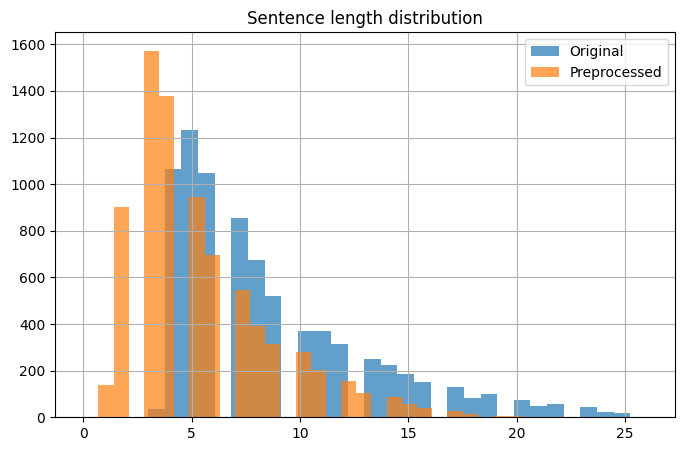

In [14]:
# Distribution of sentence lengths after preprocessing
plt.figure(figsize=(8, 5))
train_data['sentence_length'].hist(bins=30, alpha=0.7, label='Original')
train_data['lemmatized_sentence'].apply(lambda x: len(x.split())).hist(bins=30, alpha=0.7, label='Preprocessed')
plt.legend()
plt.title('Sentence length distribution')
plt.show()


After preprocessing, sentences became shorter, as evidenced by the shift of the orange distribution toward smaller lengths.

Original data peaks around 5–6 words.
Preprocessed data peaks around 4–5 words.

Sentences longer than 10 words are notably reduced in the preprocessed data.

 A small number of extremely short sentences (0–1 word) appear in the preprocessed data, potentially due to stopword removal or tokenization issues.

The reduction in sentence length is likely caused by preprocessing steps such as:

Lemmatization and stopword removal.

Removal of punctuation and unnecessary symbols.

Tokenization, which could drop certain words.

# **2. Fine-tune RuBERT**

### 2.1 Using RuBert model

We will use [DeepPavlov/rubert-base-cased](https://www.google.com/url?q=https%3A%2F%2Fhuggingface.co%2FDeepPavlov%2Frubert-base-cased) model

In [15]:
train_data.loc[train_data.acceptable == 0].sample(5)[['augmented_sentence', 'acceptable']]

,augmented_sentence,acceptable
2990,девочка давать зайти магазин,0
6428,генрих манна право считаться один великий проз...,0
4167,готовиться война 1812 г франция россия начать ...,0
7092,знать прийти время море быть плавать пароход с...,0
7769,способность человек деятельность вызывать сомн...,0


In [16]:
# Getting the lists of sentences and their labels.
sentences = train_data.sentence.values
labels = train_data.acceptable.values

In [17]:
# Loading the tokenizer.
from transformers import AutoTokenizer, AutoModelForMaskedLM

tokenizer = AutoTokenizer.from_pretrained("DeepPavlov/rubert-base-cased", do_lower_case=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [18]:
# Printing the original sentence.
print(' Original: ', sentences[0])

# Printing the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(sentences[0]))

# Printing the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[0])))

 Original:  Вдруг решетка беззвучно поехала в сторону, и на балконе возникла таинственная фигура, прячущаяся от лунного света, и погрозила Ивану пальцем.
Tokenized:  ['вдруг', 'решет', '##ка', 'безз', '##вуч', '##но', 'поехала', 'в', 'сторону', ',', 'и', 'на', 'балкон', '##е', 'возникла', 'таин', '##ственная', 'фигура', ',', 'пряч', '##ущая', '##ся', 'от', 'лунного', 'света', ',', 'и', 'пог', '##роз', '##ила', 'ива', '##ну', 'пальцем', '.']
Token IDs:  [38987, 42143, 1714, 46826, 16530, 1438, 91687, 845, 13693, 128, 851, 1469, 73783, 842, 23808, 32028, 14975, 30046, 128, 43558, 28060, 1523, 1641, 64650, 18928, 128, 851, 5500, 8380, 3297, 109909, 4650, 83837, 132]


In [19]:
max_len = 0

for sent in sentences:

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = tokenizer.encode(sent, add_special_tokens=True)

    # Update the maximum sentence length.
    max_len = max(max_len, len(input_ids))

print('Max sentence length: ', max_len)

Max sentence length:  50


In [20]:
# Tokenizing all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

for sent in sentences:

    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 64,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )

    # Add the encoded sentence to the list.
    input_ids.append(encoded_dict['input_ids'])

    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Print tensor shapes for debugging
print('Input IDs shape:', input_ids.shape)
print('Attention Masks shape:', attention_masks.shape)
print('Labels shape:', labels.shape)

# Print sentence 0, now as a list of IDs.
print('Original: ', sentences[0])
print('Token IDs:', input_ids[0])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2834: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Input IDs shape: torch.Size([7869, 64])
Attention Masks shape: torch.Size([7869, 64])
Labels shape: torch.Size([7869])
Original:  Вдруг решетка беззвучно поехала в сторону, и на балконе возникла таинственная фигура, прячущаяся от лунного света, и погрозила Ивану пальцем.
Token IDs: tensor([   101,  38987,  42143,   1714,  46826,  16530,   1438,  91687,    845,
         13693,    128,    851,   1469,  73783,    842,  23808,  32028,  14975,
         30046,    128,  43558,  28060,   1523,   1641,  64650,  18928,    128,
           851,   5500,   8380,   3297, 109909,   4650,  83837,    132,    102,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0])


In [21]:
from torch.utils.data import TensorDataset, random_split

# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(input_ids, attention_masks, labels)

# Create a 90-10 train-validation split.

# Calculate the number of samples to include in each set.
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

# Set the seed for reproducibility
generator = torch.Generator().manual_seed(42)

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size], generator=generator)

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

7,082 training samples
  787 validation samples


In [22]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it
# here. For fine-tuning BERT on a specific task, the authors recommend a batch
# size of 16 or 32.
batch_size = 32

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order.
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

### 2.2 Fine-tuning RuBERT on RuCoLa

In this section I replaced the original implementation that directly loaded a pre-trained BERT model for sequence classification with a modified version that incorporates LoRA

In [23]:
from transformers import AutoModelForSequenceClassification
from peft import LoraConfig, get_peft_model

# Configuring LoRA

lora_config = LoraConfig(
    task_type="SEQ_CLS",
    inference_mode=False,
    r=16,                       # Low-rank matrix size
    lora_alpha=32,             # Scaling factor
    lora_dropout=0.2,          # Dropout for LoRA
    target_modules=["query", "value"],
)

# Loading the pre-trained model
base_model = AutoModelForSequenceClassification.from_pretrained(
    "DeepPavlov/rubert-base-cased",
    num_labels=2,
    output_attentions=False,
    output_hidden_states=False,
)

# Applying LoRA to the pre-trained model
model = get_peft_model(base_model, lora_config)

# Print the number of trainable parameters for verification
model.print_trainable_parameters()


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import torch

# Calculating class weights
class_weights = compute_class_weight('balanced', classes=np.array([0, 1]), y=labels.numpy())
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

# Using weighted CrossEntropyLoss
loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 591,362 || all params: 178,446,340 || trainable%: 0.3314


In [24]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 251 different named parameters.

==== Embedding Layer ====

base_model.model.bert.embeddings.word_embeddings.weight (119547, 768)
base_model.model.bert.embeddings.position_embeddings.weight   (512, 768)
base_model.model.bert.embeddings.token_type_embeddings.weight     (2, 768)
base_model.model.bert.embeddings.LayerNorm.weight             (768,)
base_model.model.bert.embeddings.LayerNorm.bias               (768,)

==== First Transformer ====

base_model.model.bert.encoder.layer.0.attention.self.query.base_layer.weight   (768, 768)
base_model.model.bert.encoder.layer.0.attention.self.query.base_layer.bias       (768,)
base_model.model.bert.encoder.layer.0.attention.self.query.lora_A.default.weight    (16, 768)
base_model.model.bert.encoder.layer.0.attention.self.query.lora_B.default.weight    (768, 16)
base_model.model.bert.encoder.layer.0.attention.self.key.weight   (768, 768)
base_model.model.bert.encoder.layer.0.attention.self.key.bias       (768,)
base_model.model.

In [25]:
from transformers import BertForSequenceClassification, AdamW, BertConfig
from transformers import AutoTokenizer, AutoModel
# AdamW is a class from the huggingface library (as opposed to pytorch)
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate
                  eps = 1e-8 # args.adam_epsilon
                )

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [26]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs.
epochs = 60

# Total number of training steps is [number of batches] x [number of epochs].
total_steps = len(train_dataloader) * epochs

# Creating the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [27]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [29]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    elapsed_rounded = int(round((elapsed)))

    return str(datetime.timedelta(seconds=elapsed_rounded))

In [31]:
import random
import numpy as np
import mlflow
import torch
from sklearn.metrics import accuracy_score, matthews_corrcoef

seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss,
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# Creating a new experiment
experiment_name = "Model_Experiment"
mlflow.create_experiment(experiment_name)

mlflow.set_experiment(experiment_name)

# Start an MLflow experiment run after the training loop
with mlflow.start_run(run_name="LoRA Config Experiment"):

    for epoch_i in range(epochs):

        # ========================================
        #               Training
        # ========================================

        # Perform one full pass over the training set.
        print(f"\n======== Epoch {epoch_i + 1} / {epochs} ========")
        print('Training...')

        # Measure how long the training epoch takes.
        t0 = time.time()

        # Reset the total loss for this epoch.
        total_train_loss = 0

        # Put the model into training mode. `train` just changes the *mode*.
        model.train()

        # For each batch of training data...
        for step, batch in enumerate(train_dataloader):

            # Progress update every 40 batches.
            if step % 40 == 0 and not step == 0:
                elapsed = format_time(time.time() - t0)
                print(f'  Batch {step:>5,}  of  {len(train_dataloader):>5,}.    Elapsed: {elapsed}.')

            # Unpack this training batch from our dataloader.
            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].to(device)

            model.zero_grad()

            # Perform a forward pass (evaluate the model on this training batch).
            res = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
            logits = res['logits']  # Get logits

            # Calculate loss with the custom loss function
            loss = loss_fn(logits, b_labels)

            # Accumulate the training loss
            total_train_loss += loss.item()

            # Perform a backward pass to calculate the gradients.
            loss.backward()

            # Clip the norm of the gradients to 1.0.
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Update parameters and take a step using the computed gradient.
            optimizer.step()

            # Update the learning rate.
            scheduler.step()

        # Calculate the average loss over all of the batches.
        avg_train_loss = total_train_loss / len(train_dataloader)

        # Measure how long this epoch took.
        training_time = format_time(time.time() - t0)

        print(f"\n  Average training loss: {avg_train_loss:.2f}")
        print(f"  Training epoch took: {training_time}")

        # ========================================
        #               Validation
        # ========================================
        print("\nRunning Validation...")

        t0 = time.time()

        # Put the model in evaluation mode.
        model.eval()

        # Tracking variables
        total_eval_accuracy = 0
        total_eval_loss = 0
        nb_eval_steps = 0

        # Evaluate data for one epoch
        for batch in validation_dataloader:

            # Unpack this validation batch.
            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].to(device)

            # Tell pytorch not to bother with constructing the compute graph during the forward pass.
            with torch.no_grad():
                res = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
            loss = res['loss']
            logits = res['logits']

            # Accumulate the validation loss.
            total_eval_loss += loss.item()

            # Move logits and labels to CPU
            logits = logits.detach().cpu().numpy()
            label_ids = b_labels.to('cpu').numpy()

            # Calculate the accuracy for this batch
            total_eval_accuracy += flat_accuracy(logits, label_ids)

        # Report the final accuracy for this validation run.
        avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
        print(f"  Accuracy: {avg_val_accuracy:.2f}")

        # Calculate the average loss over all of the batches.
        avg_val_loss = total_eval_loss / len(validation_dataloader)

        # Measure how long the validation run took.
        validation_time = format_time(time.time() - t0)

        print(f"  Validation Loss: {avg_val_loss:.2f}")
        print(f"  Validation took: {validation_time}")

        # Record all statistics from this epoch.
        training_stats.append(
            {
                'epoch': epoch_i + 1,
                'Training Loss': avg_train_loss,
                'Valid. Loss': avg_val_loss,
                'Valid. Accur.': avg_val_accuracy,
                'Training Time': training_time,
                'Validation Time': validation_time
            }
        )

        # Log model after every epoch
        mlflow.pytorch.log_model(model, "model")  # Log the model

    print("\nTraining complete!")
    print(f"Total training took {format_time(time.time() - total_t0)} (h:mm:ss)")



======== Epoch 1 / 60 ========
Training...
  Batch    40  of    222.    Elapsed: 0:00:10.
  Batch    80  of    222.    Elapsed: 0:00:18.
  Batch   120  of    222.    Elapsed: 0:00:26.
  Batch   160  of    222.    Elapsed: 0:00:35.
  Batch   200  of    222.    Elapsed: 0:00:43.

  Average training loss: 0.70
  Training epoch took: 0:00:48

Running Validation...
  Accuracy: 0.42
  Validation Loss: 0.70
  Validation took: 0:00:03


2024/12/17 18:48:56 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2024/12/17 18:49:09 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2024-12-04; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'google-genai'}
2024/12/17 18:49:09 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.20.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torchvision==0.20.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version lab


======== Epoch 2 / 60 ========
Training...
  Batch    40  of    222.    Elapsed: 0:00:08.
  Batch    80  of    222.    Elapsed: 0:00:17.
  Batch   120  of    222.    Elapsed: 0:00:25.
  Batch   160  of    222.    Elapsed: 0:00:34.
  Batch   200  of    222.    Elapsed: 0:00:43.

  Average training loss: 0.69
  Training epoch took: 0:00:47

Running Validation...
  Accuracy: 0.61
  Validation Loss: 0.68
  Validation took: 0:00:03


2024/12/17 18:50:12 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2024/12/17 18:50:23 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2024-12-04; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'google-genai'}
2024/12/17 18:50:23 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.20.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torchvision==0.20.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version lab


======== Epoch 3 / 60 ========
Training...
  Batch    40  of    222.    Elapsed: 0:00:08.
  Batch    80  of    222.    Elapsed: 0:00:17.
  Batch   120  of    222.    Elapsed: 0:00:25.
  Batch   160  of    222.    Elapsed: 0:00:34.
  Batch   200  of    222.    Elapsed: 0:00:42.

  Average training loss: 0.67
  Training epoch took: 0:00:47

Running Validation...
  Accuracy: 0.64
  Validation Loss: 0.68
  Validation took: 0:00:03


2024/12/17 18:51:30 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2024/12/17 18:51:42 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2024-12-04; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'google-genai'}
2024/12/17 18:51:42 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.20.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torchvision==0.20.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version lab


======== Epoch 4 / 60 ========
Training...
  Batch    40  of    222.    Elapsed: 0:00:08.
  Batch    80  of    222.    Elapsed: 0:00:17.
  Batch   120  of    222.    Elapsed: 0:00:26.
  Batch   160  of    222.    Elapsed: 0:00:34.
  Batch   200  of    222.    Elapsed: 0:00:43.

  Average training loss: 0.67
  Training epoch took: 0:00:47

Running Validation...
  Accuracy: 0.67
  Validation Loss: 0.67
  Validation took: 0:00:03


2024/12/17 18:52:49 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2024/12/17 18:53:01 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2024-12-04; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'google-genai'}
2024/12/17 18:53:01 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.20.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torchvision==0.20.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version lab


======== Epoch 5 / 60 ========
Training...
  Batch    40  of    222.    Elapsed: 0:00:08.
  Batch    80  of    222.    Elapsed: 0:00:17.
  Batch   120  of    222.    Elapsed: 0:00:25.
  Batch   160  of    222.    Elapsed: 0:00:34.
  Batch   200  of    222.    Elapsed: 0:00:42.

  Average training loss: 0.67
  Training epoch took: 0:00:47

Running Validation...
  Accuracy: 0.65
  Validation Loss: 0.68
  Validation took: 0:00:03


2024/12/17 18:54:45 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2024/12/17 18:54:57 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2024-12-04; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'google-genai'}
2024/12/17 18:54:57 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.20.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torchvision==0.20.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version lab


======== Epoch 6 / 60 ========
Training...
  Batch    40  of    222.    Elapsed: 0:00:08.
  Batch    80  of    222.    Elapsed: 0:00:17.
  Batch   120  of    222.    Elapsed: 0:00:25.
  Batch   160  of    222.    Elapsed: 0:00:34.
  Batch   200  of    222.    Elapsed: 0:00:43.

  Average training loss: 0.67
  Training epoch took: 0:00:47

Running Validation...
  Accuracy: 0.67
  Validation Loss: 0.67
  Validation took: 0:00:03


2024/12/17 18:56:07 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2024/12/17 18:56:19 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2024-12-04; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'google-genai'}
2024/12/17 18:56:19 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.20.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torchvision==0.20.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version lab


======== Epoch 7 / 60 ========
Training...
  Batch    40  of    222.    Elapsed: 0:00:09.
  Batch    80  of    222.    Elapsed: 0:00:17.
  Batch   120  of    222.    Elapsed: 0:00:26.
  Batch   160  of    222.    Elapsed: 0:00:34.
  Batch   200  of    222.    Elapsed: 0:00:43.

  Average training loss: 0.66
  Training epoch took: 0:00:47

Running Validation...
  Accuracy: 0.64
  Validation Loss: 0.68
  Validation took: 0:00:03


2024/12/17 18:58:08 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2024/12/17 18:58:20 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2024-12-04; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'google-genai'}
2024/12/17 18:58:20 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.20.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torchvision==0.20.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version lab


======== Epoch 8 / 60 ========
Training...
  Batch    40  of    222.    Elapsed: 0:00:08.
  Batch    80  of    222.    Elapsed: 0:00:17.
  Batch   120  of    222.    Elapsed: 0:00:25.
  Batch   160  of    222.    Elapsed: 0:00:34.
  Batch   200  of    222.    Elapsed: 0:00:42.

  Average training loss: 0.66
  Training epoch took: 0:00:47

Running Validation...
  Accuracy: 0.63
  Validation Loss: 0.69
  Validation took: 0:00:03


2024/12/17 18:59:29 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2024/12/17 18:59:41 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2024-12-04; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'google-genai'}
2024/12/17 18:59:41 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.20.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torchvision==0.20.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version lab


======== Epoch 9 / 60 ========
Training...
  Batch    40  of    222.    Elapsed: 0:00:08.
  Batch    80  of    222.    Elapsed: 0:00:17.
  Batch   120  of    222.    Elapsed: 0:00:25.
  Batch   160  of    222.    Elapsed: 0:00:34.
  Batch   200  of    222.    Elapsed: 0:00:42.

  Average training loss: 0.66
  Training epoch took: 0:00:47

Running Validation...
  Accuracy: 0.67
  Validation Loss: 0.64
  Validation took: 0:00:03


2024/12/17 19:00:47 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2024/12/17 19:00:58 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2024-12-04; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'google-genai'}
2024/12/17 19:00:58 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.20.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torchvision==0.20.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version lab


======== Epoch 10 / 60 ========
Training...
  Batch    40  of    222.    Elapsed: 0:00:08.
  Batch    80  of    222.    Elapsed: 0:00:17.
  Batch   120  of    222.    Elapsed: 0:00:25.
  Batch   160  of    222.    Elapsed: 0:00:34.
  Batch   200  of    222.    Elapsed: 0:00:42.

  Average training loss: 0.65
  Training epoch took: 0:00:47

Running Validation...
  Accuracy: 0.62
  Validation Loss: 0.68
  Validation took: 0:00:03


2024/12/17 19:02:07 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2024/12/17 19:02:18 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2024-12-04; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'google-genai'}
2024/12/17 19:02:18 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.20.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torchvision==0.20.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version lab


======== Epoch 11 / 60 ========
Training...
  Batch    40  of    222.    Elapsed: 0:00:08.
  Batch    80  of    222.    Elapsed: 0:00:17.
  Batch   120  of    222.    Elapsed: 0:00:25.
  Batch   160  of    222.    Elapsed: 0:00:34.
  Batch   200  of    222.    Elapsed: 0:00:42.

  Average training loss: 0.65
  Training epoch took: 0:00:47

Running Validation...
  Accuracy: 0.69
  Validation Loss: 0.63
  Validation took: 0:00:03


2024/12/17 19:03:25 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2024/12/17 19:03:37 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2024-12-04; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'google-genai'}
2024/12/17 19:03:37 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.20.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torchvision==0.20.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version lab


======== Epoch 12 / 60 ========
Training...
  Batch    40  of    222.    Elapsed: 0:00:08.
  Batch    80  of    222.    Elapsed: 0:00:17.
  Batch   120  of    222.    Elapsed: 0:00:25.
  Batch   160  of    222.    Elapsed: 0:00:34.
  Batch   200  of    222.    Elapsed: 0:00:42.

  Average training loss: 0.64
  Training epoch took: 0:00:47

Running Validation...
  Accuracy: 0.68
  Validation Loss: 0.64
  Validation took: 0:00:03


2024/12/17 19:04:48 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2024/12/17 19:05:00 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2024-12-04; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'google-genai'}
2024/12/17 19:05:00 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.20.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torchvision==0.20.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version lab


======== Epoch 13 / 60 ========
Training...
  Batch    40  of    222.    Elapsed: 0:00:08.
  Batch    80  of    222.    Elapsed: 0:00:17.
  Batch   120  of    222.    Elapsed: 0:00:25.
  Batch   160  of    222.    Elapsed: 0:00:34.
  Batch   200  of    222.    Elapsed: 0:00:42.

  Average training loss: 0.64
  Training epoch took: 0:00:47

Running Validation...
  Accuracy: 0.70
  Validation Loss: 0.62
  Validation took: 0:00:03


2024/12/17 19:06:01 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2024/12/17 19:06:12 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2024-12-04; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'google-genai'}
2024/12/17 19:06:13 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.20.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torchvision==0.20.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version lab


======== Epoch 14 / 60 ========
Training...
  Batch    40  of    222.    Elapsed: 0:00:08.
  Batch    80  of    222.    Elapsed: 0:00:17.
  Batch   120  of    222.    Elapsed: 0:00:25.
  Batch   160  of    222.    Elapsed: 0:00:34.
  Batch   200  of    222.    Elapsed: 0:00:42.

  Average training loss: 0.63
  Training epoch took: 0:00:47

Running Validation...
  Accuracy: 0.70
  Validation Loss: 0.62
  Validation took: 0:00:03


2024/12/17 19:07:29 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2024/12/17 19:07:43 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2024-12-04; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'google-genai'}
2024/12/17 19:07:43 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.20.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torchvision==0.20.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version lab


======== Epoch 15 / 60 ========
Training...
  Batch    40  of    222.    Elapsed: 0:00:08.
  Batch    80  of    222.    Elapsed: 0:00:17.
  Batch   120  of    222.    Elapsed: 0:00:25.
  Batch   160  of    222.    Elapsed: 0:00:34.
  Batch   200  of    222.    Elapsed: 0:00:42.

  Average training loss: 0.63
  Training epoch took: 0:00:47

Running Validation...
  Accuracy: 0.70
  Validation Loss: 0.61
  Validation took: 0:00:03


2024/12/17 19:08:49 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2024/12/17 19:09:00 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2024-12-04; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'google-genai'}
2024/12/17 19:09:00 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.20.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torchvision==0.20.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version lab


======== Epoch 16 / 60 ========
Training...
  Batch    40  of    222.    Elapsed: 0:00:08.
  Batch    80  of    222.    Elapsed: 0:00:17.
  Batch   120  of    222.    Elapsed: 0:00:25.
  Batch   160  of    222.    Elapsed: 0:00:34.
  Batch   200  of    222.    Elapsed: 0:00:42.

  Average training loss: 0.63
  Training epoch took: 0:00:47

Running Validation...
  Accuracy: 0.71
  Validation Loss: 0.61
  Validation took: 0:00:03


2024/12/17 19:10:06 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2024/12/17 19:10:17 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2024-12-04; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'google-genai'}
2024/12/17 19:10:17 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.20.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torchvision==0.20.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version lab


======== Epoch 17 / 60 ========
Training...
  Batch    40  of    222.    Elapsed: 0:00:08.
  Batch    80  of    222.    Elapsed: 0:00:17.
  Batch   120  of    222.    Elapsed: 0:00:25.
  Batch   160  of    222.    Elapsed: 0:00:34.
  Batch   200  of    222.    Elapsed: 0:00:42.

  Average training loss: 0.63
  Training epoch took: 0:00:47

Running Validation...
  Accuracy: 0.71
  Validation Loss: 0.61
  Validation took: 0:00:03


2024/12/17 19:11:28 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2024/12/17 19:11:40 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2024-12-04; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'google-genai'}
2024/12/17 19:11:40 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.20.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torchvision==0.20.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version lab


======== Epoch 18 / 60 ========
Training...
  Batch    40  of    222.    Elapsed: 0:00:08.
  Batch    80  of    222.    Elapsed: 0:00:17.
  Batch   120  of    222.    Elapsed: 0:00:25.
  Batch   160  of    222.    Elapsed: 0:00:34.
  Batch   200  of    222.    Elapsed: 0:00:42.

  Average training loss: 0.62
  Training epoch took: 0:00:47

Running Validation...
  Accuracy: 0.65
  Validation Loss: 0.66
  Validation took: 0:00:03


2024/12/17 19:12:46 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2024/12/17 19:12:57 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2024-12-04; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'google-genai'}
2024/12/17 19:12:57 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.20.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torchvision==0.20.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version lab


======== Epoch 19 / 60 ========
Training...
  Batch    40  of    222.    Elapsed: 0:00:08.
  Batch    80  of    222.    Elapsed: 0:00:17.
  Batch   120  of    222.    Elapsed: 0:00:25.
  Batch   160  of    222.    Elapsed: 0:00:34.
  Batch   200  of    222.    Elapsed: 0:00:42.

  Average training loss: 0.61
  Training epoch took: 0:00:47

Running Validation...
  Accuracy: 0.73
  Validation Loss: 0.58
  Validation took: 0:00:03


2024/12/17 19:14:47 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2024/12/17 19:14:58 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2024-12-04; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'google-genai'}
2024/12/17 19:14:58 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.20.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torchvision==0.20.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version lab


======== Epoch 20 / 60 ========
Training...
  Batch    40  of    222.    Elapsed: 0:00:08.
  Batch    80  of    222.    Elapsed: 0:00:17.
  Batch   120  of    222.    Elapsed: 0:00:25.
  Batch   160  of    222.    Elapsed: 0:00:34.
  Batch   200  of    222.    Elapsed: 0:00:42.

  Average training loss: 0.62
  Training epoch took: 0:00:47

Running Validation...
  Accuracy: 0.71
  Validation Loss: 0.62
  Validation took: 0:00:03


2024/12/17 19:16:02 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2024/12/17 19:16:13 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2024-12-04; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'google-genai'}
2024/12/17 19:16:13 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.20.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torchvision==0.20.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version lab


======== Epoch 21 / 60 ========
Training...
  Batch    40  of    222.    Elapsed: 0:00:08.
  Batch    80  of    222.    Elapsed: 0:00:17.
  Batch   120  of    222.    Elapsed: 0:00:25.
  Batch   160  of    222.    Elapsed: 0:00:34.
  Batch   200  of    222.    Elapsed: 0:00:42.

  Average training loss: 0.61
  Training epoch took: 0:00:47

Running Validation...
  Accuracy: 0.70
  Validation Loss: 0.62
  Validation took: 0:00:03


2024/12/17 19:17:29 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2024/12/17 19:17:40 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2024-12-04; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'google-genai'}
2024/12/17 19:17:40 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.20.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torchvision==0.20.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version lab


======== Epoch 22 / 60 ========
Training...
  Batch    40  of    222.    Elapsed: 0:00:08.
  Batch    80  of    222.    Elapsed: 0:00:17.
  Batch   120  of    222.    Elapsed: 0:00:25.
  Batch   160  of    222.    Elapsed: 0:00:34.
  Batch   200  of    222.    Elapsed: 0:00:42.

  Average training loss: 0.61
  Training epoch took: 0:00:47

Running Validation...
  Accuracy: 0.71
  Validation Loss: 0.62
  Validation took: 0:00:03


2024/12/17 19:18:46 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2024/12/17 19:18:57 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2024-12-04; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'google-genai'}
2024/12/17 19:18:57 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.20.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torchvision==0.20.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version lab


======== Epoch 23 / 60 ========
Training...
  Batch    40  of    222.    Elapsed: 0:00:08.
  Batch    80  of    222.    Elapsed: 0:00:17.
  Batch   120  of    222.    Elapsed: 0:00:25.
  Batch   160  of    222.    Elapsed: 0:00:34.
  Batch   200  of    222.    Elapsed: 0:00:42.

  Average training loss: 0.61
  Training epoch took: 0:00:47

Running Validation...
  Accuracy: 0.72
  Validation Loss: 0.60
  Validation took: 0:00:03


2024/12/17 19:20:06 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2024/12/17 19:20:18 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2024-12-04; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'google-genai'}
2024/12/17 19:20:18 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.20.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torchvision==0.20.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version lab


======== Epoch 24 / 60 ========
Training...
  Batch    40  of    222.    Elapsed: 0:00:08.
  Batch    80  of    222.    Elapsed: 0:00:17.
  Batch   120  of    222.    Elapsed: 0:00:25.
  Batch   160  of    222.    Elapsed: 0:00:34.
  Batch   200  of    222.    Elapsed: 0:00:42.

  Average training loss: 0.60
  Training epoch took: 0:00:47

Running Validation...
  Accuracy: 0.72
  Validation Loss: 0.60
  Validation took: 0:00:03


2024/12/17 19:21:26 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2024/12/17 19:21:38 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2024-12-04; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'google-genai'}
2024/12/17 19:21:38 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.20.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torchvision==0.20.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version lab


======== Epoch 25 / 60 ========
Training...
  Batch    40  of    222.    Elapsed: 0:00:08.
  Batch    80  of    222.    Elapsed: 0:00:17.
  Batch   120  of    222.    Elapsed: 0:00:25.
  Batch   160  of    222.    Elapsed: 0:00:34.
  Batch   200  of    222.    Elapsed: 0:00:42.

  Average training loss: 0.61
  Training epoch took: 0:00:47

Running Validation...
  Accuracy: 0.73
  Validation Loss: 0.58
  Validation took: 0:00:03


2024/12/17 19:22:48 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2024/12/17 19:22:59 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2024-12-04; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'google-genai'}
2024/12/17 19:22:59 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.20.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torchvision==0.20.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version lab


======== Epoch 26 / 60 ========
Training...
  Batch    40  of    222.    Elapsed: 0:00:08.
  Batch    80  of    222.    Elapsed: 0:00:17.
  Batch   120  of    222.    Elapsed: 0:00:25.
  Batch   160  of    222.    Elapsed: 0:00:34.
  Batch   200  of    222.    Elapsed: 0:00:42.

  Average training loss: 0.60
  Training epoch took: 0:00:47

Running Validation...
  Accuracy: 0.73
  Validation Loss: 0.59
  Validation took: 0:00:03


2024/12/17 19:24:11 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2024/12/17 19:24:23 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2024-12-04; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'google-genai'}
2024/12/17 19:24:23 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.20.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torchvision==0.20.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version lab


======== Epoch 27 / 60 ========
Training...
  Batch    40  of    222.    Elapsed: 0:00:08.
  Batch    80  of    222.    Elapsed: 0:00:17.
  Batch   120  of    222.    Elapsed: 0:00:25.
  Batch   160  of    222.    Elapsed: 0:00:34.
  Batch   200  of    222.    Elapsed: 0:00:42.

  Average training loss: 0.60
  Training epoch took: 0:00:47

Running Validation...
  Accuracy: 0.73
  Validation Loss: 0.59
  Validation took: 0:00:03


2024/12/17 19:25:26 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2024/12/17 19:25:38 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2024-12-04; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'google-genai'}
2024/12/17 19:25:38 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.20.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torchvision==0.20.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version lab


======== Epoch 28 / 60 ========
Training...
  Batch    40  of    222.    Elapsed: 0:00:08.
  Batch    80  of    222.    Elapsed: 0:00:17.
  Batch   120  of    222.    Elapsed: 0:00:26.
  Batch   160  of    222.    Elapsed: 0:00:34.
  Batch   200  of    222.    Elapsed: 0:00:43.

  Average training loss: 0.59
  Training epoch took: 0:00:48

Running Validation...
  Accuracy: 0.74
  Validation Loss: 0.56
  Validation took: 0:00:03


2024/12/17 19:26:43 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2024/12/17 19:26:55 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2024-12-04; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'google-genai'}
2024/12/17 19:26:55 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.20.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torchvision==0.20.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version lab


======== Epoch 29 / 60 ========
Training...
  Batch    40  of    222.    Elapsed: 0:00:08.
  Batch    80  of    222.    Elapsed: 0:00:17.
  Batch   120  of    222.    Elapsed: 0:00:25.
  Batch   160  of    222.    Elapsed: 0:00:34.
  Batch   200  of    222.    Elapsed: 0:00:42.

  Average training loss: 0.59
  Training epoch took: 0:00:47

Running Validation...
  Accuracy: 0.72
  Validation Loss: 0.60
  Validation took: 0:00:03


2024/12/17 19:28:10 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2024/12/17 19:28:21 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2024-12-04; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'google-genai'}
2024/12/17 19:28:21 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.20.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torchvision==0.20.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version lab


======== Epoch 30 / 60 ========
Training...
  Batch    40  of    222.    Elapsed: 0:00:08.
  Batch    80  of    222.    Elapsed: 0:00:17.
  Batch   120  of    222.    Elapsed: 0:00:25.
  Batch   160  of    222.    Elapsed: 0:00:34.
  Batch   200  of    222.    Elapsed: 0:00:42.

  Average training loss: 0.59
  Training epoch took: 0:00:47

Running Validation...
  Accuracy: 0.74
  Validation Loss: 0.55
  Validation took: 0:00:03


2024/12/17 19:29:27 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2024/12/17 19:29:38 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2024-12-04; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'google-genai'}
2024/12/17 19:29:38 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.20.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torchvision==0.20.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version lab


======== Epoch 31 / 60 ========
Training...
  Batch    40  of    222.    Elapsed: 0:00:08.
  Batch    80  of    222.    Elapsed: 0:00:17.
  Batch   120  of    222.    Elapsed: 0:00:25.
  Batch   160  of    222.    Elapsed: 0:00:34.
  Batch   200  of    222.    Elapsed: 0:00:42.

  Average training loss: 0.59
  Training epoch took: 0:00:47

Running Validation...
  Accuracy: 0.72
  Validation Loss: 0.58
  Validation took: 0:00:03


2024/12/17 19:30:49 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2024/12/17 19:31:00 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2024-12-04; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'google-genai'}
2024/12/17 19:31:00 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.20.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torchvision==0.20.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version lab


======== Epoch 32 / 60 ========
Training...
  Batch    40  of    222.    Elapsed: 0:00:08.
  Batch    80  of    222.    Elapsed: 0:00:17.
  Batch   120  of    222.    Elapsed: 0:00:25.
  Batch   160  of    222.    Elapsed: 0:00:34.
  Batch   200  of    222.    Elapsed: 0:00:42.

  Average training loss: 0.58
  Training epoch took: 0:00:47

Running Validation...
  Accuracy: 0.74
  Validation Loss: 0.56
  Validation took: 0:00:03


2024/12/17 19:32:05 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2024/12/17 19:32:17 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2024-12-04; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'google-genai'}
2024/12/17 19:32:17 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.20.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torchvision==0.20.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version lab


======== Epoch 33 / 60 ========
Training...
  Batch    40  of    222.    Elapsed: 0:00:08.
  Batch    80  of    222.    Elapsed: 0:00:17.
  Batch   120  of    222.    Elapsed: 0:00:25.
  Batch   160  of    222.    Elapsed: 0:00:34.
  Batch   200  of    222.    Elapsed: 0:00:42.

  Average training loss: 0.59
  Training epoch took: 0:00:47

Running Validation...
  Accuracy: 0.74
  Validation Loss: 0.56
  Validation took: 0:00:03


2024/12/17 19:33:59 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2024/12/17 19:34:11 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2024-12-04; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'google-genai'}
2024/12/17 19:34:11 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.20.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torchvision==0.20.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version lab


======== Epoch 34 / 60 ========
Training...
  Batch    40  of    222.    Elapsed: 0:00:08.
  Batch    80  of    222.    Elapsed: 0:00:17.
  Batch   120  of    222.    Elapsed: 0:00:25.
  Batch   160  of    222.    Elapsed: 0:00:34.
  Batch   200  of    222.    Elapsed: 0:00:42.

  Average training loss: 0.58
  Training epoch took: 0:00:47

Running Validation...
  Accuracy: 0.73
  Validation Loss: 0.58
  Validation took: 0:00:03


2024/12/17 19:35:10 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2024/12/17 19:35:21 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2024-12-04; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'google-genai'}
2024/12/17 19:35:21 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.20.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torchvision==0.20.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version lab


======== Epoch 35 / 60 ========
Training...
  Batch    40  of    222.    Elapsed: 0:00:08.
  Batch    80  of    222.    Elapsed: 0:00:17.
  Batch   120  of    222.    Elapsed: 0:00:25.
  Batch   160  of    222.    Elapsed: 0:00:34.
  Batch   200  of    222.    Elapsed: 0:00:42.

  Average training loss: 0.57
  Training epoch took: 0:00:47

Running Validation...
  Accuracy: 0.74
  Validation Loss: 0.56
  Validation took: 0:00:03


2024/12/17 19:37:14 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2024/12/17 19:37:25 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2024-12-04; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'google-genai'}
2024/12/17 19:37:25 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.20.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torchvision==0.20.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version lab


======== Epoch 36 / 60 ========
Training...
  Batch    40  of    222.    Elapsed: 0:00:08.
  Batch    80  of    222.    Elapsed: 0:00:17.
  Batch   120  of    222.    Elapsed: 0:00:25.
  Batch   160  of    222.    Elapsed: 0:00:34.
  Batch   200  of    222.    Elapsed: 0:00:42.

  Average training loss: 0.57
  Training epoch took: 0:00:47

Running Validation...
  Accuracy: 0.75
  Validation Loss: 0.55
  Validation took: 0:00:03


2024/12/17 19:38:31 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2024/12/17 19:38:41 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2024-12-04; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'google-genai'}
2024/12/17 19:38:41 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.20.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torchvision==0.20.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version lab


======== Epoch 37 / 60 ========
Training...
  Batch    40  of    222.    Elapsed: 0:00:08.
  Batch    80  of    222.    Elapsed: 0:00:17.
  Batch   120  of    222.    Elapsed: 0:00:25.
  Batch   160  of    222.    Elapsed: 0:00:34.
  Batch   200  of    222.    Elapsed: 0:00:42.

  Average training loss: 0.57
  Training epoch took: 0:00:47

Running Validation...
  Accuracy: 0.72
  Validation Loss: 0.59
  Validation took: 0:00:03


2024/12/17 19:39:56 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2024/12/17 19:40:08 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2024-12-04; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'google-genai'}
2024/12/17 19:40:08 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.20.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torchvision==0.20.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version lab


======== Epoch 38 / 60 ========
Training...
  Batch    40  of    222.    Elapsed: 0:00:08.
  Batch    80  of    222.    Elapsed: 0:00:17.
  Batch   120  of    222.    Elapsed: 0:00:25.
  Batch   160  of    222.    Elapsed: 0:00:34.
  Batch   200  of    222.    Elapsed: 0:00:42.

  Average training loss: 0.57
  Training epoch took: 0:00:47

Running Validation...
  Accuracy: 0.73
  Validation Loss: 0.57
  Validation took: 0:00:03


2024/12/17 19:41:54 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2024/12/17 19:42:05 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2024-12-04; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'google-genai'}
2024/12/17 19:42:05 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.20.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torchvision==0.20.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version lab


======== Epoch 39 / 60 ========
Training...
  Batch    40  of    222.    Elapsed: 0:00:08.
  Batch    80  of    222.    Elapsed: 0:00:17.
  Batch   120  of    222.    Elapsed: 0:00:25.
  Batch   160  of    222.    Elapsed: 0:00:34.
  Batch   200  of    222.    Elapsed: 0:00:42.

  Average training loss: 0.57
  Training epoch took: 0:00:47

Running Validation...
  Accuracy: 0.74
  Validation Loss: 0.55
  Validation took: 0:00:03


2024/12/17 19:43:15 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2024/12/17 19:43:26 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2024-12-04; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'google-genai'}
2024/12/17 19:43:26 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.20.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torchvision==0.20.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version lab


======== Epoch 40 / 60 ========
Training...
  Batch    40  of    222.    Elapsed: 0:00:08.
  Batch    80  of    222.    Elapsed: 0:00:17.
  Batch   120  of    222.    Elapsed: 0:00:25.
  Batch   160  of    222.    Elapsed: 0:00:34.
  Batch   200  of    222.    Elapsed: 0:00:42.

  Average training loss: 0.57
  Training epoch took: 0:00:47

Running Validation...
  Accuracy: 0.76
  Validation Loss: 0.54
  Validation took: 0:00:03


2024/12/17 19:45:08 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2024/12/17 19:45:20 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2024-12-04; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'google-genai'}
2024/12/17 19:45:20 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.20.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torchvision==0.20.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version lab


======== Epoch 41 / 60 ========
Training...
  Batch    40  of    222.    Elapsed: 0:00:08.
  Batch    80  of    222.    Elapsed: 0:00:17.
  Batch   120  of    222.    Elapsed: 0:00:25.
  Batch   160  of    222.    Elapsed: 0:00:34.
  Batch   200  of    222.    Elapsed: 0:00:42.

  Average training loss: 0.56
  Training epoch took: 0:00:47

Running Validation...
  Accuracy: 0.75
  Validation Loss: 0.55
  Validation took: 0:00:03


2024/12/17 19:46:19 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2024/12/17 19:46:31 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2024-12-04; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'google-genai'}
2024/12/17 19:46:31 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.20.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torchvision==0.20.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version lab


======== Epoch 42 / 60 ========
Training...
  Batch    40  of    222.    Elapsed: 0:00:08.
  Batch    80  of    222.    Elapsed: 0:00:17.
  Batch   120  of    222.    Elapsed: 0:00:25.
  Batch   160  of    222.    Elapsed: 0:00:34.
  Batch   200  of    222.    Elapsed: 0:00:42.

  Average training loss: 0.56
  Training epoch took: 0:00:47

Running Validation...
  Accuracy: 0.75
  Validation Loss: 0.54
  Validation took: 0:00:03


2024/12/17 19:47:41 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2024/12/17 19:47:52 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2024-12-04; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'google-genai'}
2024/12/17 19:47:52 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.20.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torchvision==0.20.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version lab


======== Epoch 43 / 60 ========
Training...
  Batch    40  of    222.    Elapsed: 0:00:08.
  Batch    80  of    222.    Elapsed: 0:00:17.
  Batch   120  of    222.    Elapsed: 0:00:25.
  Batch   160  of    222.    Elapsed: 0:00:34.
  Batch   200  of    222.    Elapsed: 0:00:42.

  Average training loss: 0.56
  Training epoch took: 0:00:47

Running Validation...
  Accuracy: 0.73
  Validation Loss: 0.57
  Validation took: 0:00:03


2024/12/17 19:48:53 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2024/12/17 19:49:04 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2024-12-04; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'google-genai'}
2024/12/17 19:49:04 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.20.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torchvision==0.20.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version lab


======== Epoch 44 / 60 ========
Training...
  Batch    40  of    222.    Elapsed: 0:00:08.
  Batch    80  of    222.    Elapsed: 0:00:17.
  Batch   120  of    222.    Elapsed: 0:00:25.
  Batch   160  of    222.    Elapsed: 0:00:34.
  Batch   200  of    222.    Elapsed: 0:00:42.

  Average training loss: 0.56
  Training epoch took: 0:00:47

Running Validation...
  Accuracy: 0.75
  Validation Loss: 0.54
  Validation took: 0:00:03


2024/12/17 19:50:11 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2024/12/17 19:50:24 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2024-12-04; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'google-genai'}
2024/12/17 19:50:24 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.20.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torchvision==0.20.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version lab


======== Epoch 45 / 60 ========
Training...
  Batch    40  of    222.    Elapsed: 0:00:08.
  Batch    80  of    222.    Elapsed: 0:00:17.
  Batch   120  of    222.    Elapsed: 0:00:25.
  Batch   160  of    222.    Elapsed: 0:00:34.
  Batch   200  of    222.    Elapsed: 0:00:42.

  Average training loss: 0.56
  Training epoch took: 0:00:47

Running Validation...
  Accuracy: 0.76
  Validation Loss: 0.54
  Validation took: 0:00:03


2024/12/17 19:51:28 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2024/12/17 19:51:40 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2024-12-04; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'google-genai'}
2024/12/17 19:51:40 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.20.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torchvision==0.20.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version lab


======== Epoch 46 / 60 ========
Training...
  Batch    40  of    222.    Elapsed: 0:00:08.
  Batch    80  of    222.    Elapsed: 0:00:17.
  Batch   120  of    222.    Elapsed: 0:00:25.
  Batch   160  of    222.    Elapsed: 0:00:34.
  Batch   200  of    222.    Elapsed: 0:00:42.

  Average training loss: 0.56
  Training epoch took: 0:00:47

Running Validation...
  Accuracy: 0.73
  Validation Loss: 0.56
  Validation took: 0:00:03


2024/12/17 19:53:01 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2024/12/17 19:53:12 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2024-12-04; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'google-genai'}
2024/12/17 19:53:12 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.20.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torchvision==0.20.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version lab


======== Epoch 47 / 60 ========
Training...
  Batch    40  of    222.    Elapsed: 0:00:08.
  Batch    80  of    222.    Elapsed: 0:00:17.
  Batch   120  of    222.    Elapsed: 0:00:25.
  Batch   160  of    222.    Elapsed: 0:00:34.
  Batch   200  of    222.    Elapsed: 0:00:42.

  Average training loss: 0.56
  Training epoch took: 0:00:47

Running Validation...
  Accuracy: 0.75
  Validation Loss: 0.56
  Validation took: 0:00:03


2024/12/17 19:54:18 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2024/12/17 19:54:30 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2024-12-04; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'google-genai'}
2024/12/17 19:54:30 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.20.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torchvision==0.20.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version lab


======== Epoch 48 / 60 ========
Training...
  Batch    40  of    222.    Elapsed: 0:00:08.
  Batch    80  of    222.    Elapsed: 0:00:17.
  Batch   120  of    222.    Elapsed: 0:00:25.
  Batch   160  of    222.    Elapsed: 0:00:34.
  Batch   200  of    222.    Elapsed: 0:00:42.

  Average training loss: 0.55
  Training epoch took: 0:00:47

Running Validation...
  Accuracy: 0.75
  Validation Loss: 0.55
  Validation took: 0:00:03


2024/12/17 19:55:31 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2024/12/17 19:55:42 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2024-12-04; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'google-genai'}
2024/12/17 19:55:42 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.20.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torchvision==0.20.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version lab


======== Epoch 49 / 60 ========
Training...
  Batch    40  of    222.    Elapsed: 0:00:08.
  Batch    80  of    222.    Elapsed: 0:00:17.
  Batch   120  of    222.    Elapsed: 0:00:25.
  Batch   160  of    222.    Elapsed: 0:00:34.
  Batch   200  of    222.    Elapsed: 0:00:42.

  Average training loss: 0.56
  Training epoch took: 0:00:47

Running Validation...
  Accuracy: 0.74
  Validation Loss: 0.56
  Validation took: 0:00:03


2024/12/17 19:57:25 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2024/12/17 19:57:37 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2024-12-04; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'google-genai'}
2024/12/17 19:57:37 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.20.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torchvision==0.20.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version lab


======== Epoch 50 / 60 ========
Training...
  Batch    40  of    222.    Elapsed: 0:00:08.
  Batch    80  of    222.    Elapsed: 0:00:17.
  Batch   120  of    222.    Elapsed: 0:00:25.
  Batch   160  of    222.    Elapsed: 0:00:34.
  Batch   200  of    222.    Elapsed: 0:00:42.

  Average training loss: 0.56
  Training epoch took: 0:00:47

Running Validation...
  Accuracy: 0.75
  Validation Loss: 0.54
  Validation took: 0:00:03


2024/12/17 19:58:41 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2024/12/17 19:58:51 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2024-12-04; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'google-genai'}
2024/12/17 19:58:51 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.20.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torchvision==0.20.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version lab


======== Epoch 51 / 60 ========
Training...
  Batch    40  of    222.    Elapsed: 0:00:08.
  Batch    80  of    222.    Elapsed: 0:00:17.
  Batch   120  of    222.    Elapsed: 0:00:25.
  Batch   160  of    222.    Elapsed: 0:00:34.
  Batch   200  of    222.    Elapsed: 0:00:42.

  Average training loss: 0.56
  Training epoch took: 0:00:47

Running Validation...
  Accuracy: 0.75
  Validation Loss: 0.54
  Validation took: 0:00:03


2024/12/17 19:59:51 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2024/12/17 20:00:02 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2024-12-04; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'google-genai'}
2024/12/17 20:00:02 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.20.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torchvision==0.20.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version lab


======== Epoch 52 / 60 ========
Training...
  Batch    40  of    222.    Elapsed: 0:00:08.
  Batch    80  of    222.    Elapsed: 0:00:17.
  Batch   120  of    222.    Elapsed: 0:00:25.
  Batch   160  of    222.    Elapsed: 0:00:34.
  Batch   200  of    222.    Elapsed: 0:00:42.

  Average training loss: 0.55
  Training epoch took: 0:00:47

Running Validation...
  Accuracy: 0.75
  Validation Loss: 0.55
  Validation took: 0:00:03


2024/12/17 20:01:16 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2024/12/17 20:01:27 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2024-12-04; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'google-genai'}
2024/12/17 20:01:27 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.20.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torchvision==0.20.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version lab


======== Epoch 53 / 60 ========
Training...
  Batch    40  of    222.    Elapsed: 0:00:08.
  Batch    80  of    222.    Elapsed: 0:00:17.
  Batch   120  of    222.    Elapsed: 0:00:25.
  Batch   160  of    222.    Elapsed: 0:00:34.
  Batch   200  of    222.    Elapsed: 0:00:42.

  Average training loss: 0.55
  Training epoch took: 0:00:47

Running Validation...
  Accuracy: 0.75
  Validation Loss: 0.55
  Validation took: 0:00:03


2024/12/17 20:02:32 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2024/12/17 20:02:43 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2024-12-04; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'google-genai'}
2024/12/17 20:02:43 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.20.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torchvision==0.20.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version lab


======== Epoch 54 / 60 ========
Training...
  Batch    40  of    222.    Elapsed: 0:00:08.
  Batch    80  of    222.    Elapsed: 0:00:17.
  Batch   120  of    222.    Elapsed: 0:00:25.
  Batch   160  of    222.    Elapsed: 0:00:34.
  Batch   200  of    222.    Elapsed: 0:00:42.

  Average training loss: 0.55
  Training epoch took: 0:00:47

Running Validation...
  Accuracy: 0.76
  Validation Loss: 0.54
  Validation took: 0:00:03


2024/12/17 20:03:54 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2024/12/17 20:04:06 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2024-12-04; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'google-genai'}
2024/12/17 20:04:06 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.20.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torchvision==0.20.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version lab


======== Epoch 55 / 60 ========
Training...
  Batch    40  of    222.    Elapsed: 0:00:08.
  Batch    80  of    222.    Elapsed: 0:00:17.
  Batch   120  of    222.    Elapsed: 0:00:25.
  Batch   160  of    222.    Elapsed: 0:00:34.
  Batch   200  of    222.    Elapsed: 0:00:42.

  Average training loss: 0.54
  Training epoch took: 0:00:47

Running Validation...
  Accuracy: 0.75
  Validation Loss: 0.55
  Validation took: 0:00:03


2024/12/17 20:05:12 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2024/12/17 20:05:23 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2024-12-04; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'google-genai'}
2024/12/17 20:05:23 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.20.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torchvision==0.20.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version lab


======== Epoch 56 / 60 ========
Training...
  Batch    40  of    222.    Elapsed: 0:00:08.
  Batch    80  of    222.    Elapsed: 0:00:17.
  Batch   120  of    222.    Elapsed: 0:00:25.
  Batch   160  of    222.    Elapsed: 0:00:34.
  Batch   200  of    222.    Elapsed: 0:00:42.

  Average training loss: 0.55
  Training epoch took: 0:00:47

Running Validation...
  Accuracy: 0.75
  Validation Loss: 0.55
  Validation took: 0:00:03


2024/12/17 20:06:27 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2024/12/17 20:06:38 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2024-12-04; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'google-genai'}
2024/12/17 20:06:38 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.20.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torchvision==0.20.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version lab


======== Epoch 57 / 60 ========
Training...
  Batch    40  of    222.    Elapsed: 0:00:08.
  Batch    80  of    222.    Elapsed: 0:00:17.
  Batch   120  of    222.    Elapsed: 0:00:25.
  Batch   160  of    222.    Elapsed: 0:00:34.
  Batch   200  of    222.    Elapsed: 0:00:42.

  Average training loss: 0.54
  Training epoch took: 0:00:47

Running Validation...
  Accuracy: 0.76
  Validation Loss: 0.54
  Validation took: 0:00:03


2024/12/17 20:07:43 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2024/12/17 20:07:54 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2024-12-04; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'google-genai'}
2024/12/17 20:07:54 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.20.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torchvision==0.20.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version lab


======== Epoch 58 / 60 ========
Training...
  Batch    40  of    222.    Elapsed: 0:00:08.
  Batch    80  of    222.    Elapsed: 0:00:17.
  Batch   120  of    222.    Elapsed: 0:00:25.
  Batch   160  of    222.    Elapsed: 0:00:34.
  Batch   200  of    222.    Elapsed: 0:00:42.

  Average training loss: 0.55
  Training epoch took: 0:00:47

Running Validation...
  Accuracy: 0.75
  Validation Loss: 0.54
  Validation took: 0:00:03


2024/12/17 20:08:59 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2024/12/17 20:09:10 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2024-12-04; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'google-genai'}
2024/12/17 20:09:10 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.20.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torchvision==0.20.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version lab


======== Epoch 59 / 60 ========
Training...
  Batch    40  of    222.    Elapsed: 0:00:08.
  Batch    80  of    222.    Elapsed: 0:00:17.
  Batch   120  of    222.    Elapsed: 0:00:25.
  Batch   160  of    222.    Elapsed: 0:00:34.
  Batch   200  of    222.    Elapsed: 0:00:42.

  Average training loss: 0.55
  Training epoch took: 0:00:47

Running Validation...
  Accuracy: 0.76
  Validation Loss: 0.54
  Validation took: 0:00:03


2024/12/17 20:10:10 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2024/12/17 20:10:22 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2024-12-04; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'google-genai'}
2024/12/17 20:10:22 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.20.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torchvision==0.20.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version lab


======== Epoch 60 / 60 ========
Training...
  Batch    40  of    222.    Elapsed: 0:00:08.
  Batch    80  of    222.    Elapsed: 0:00:17.
  Batch   120  of    222.    Elapsed: 0:00:25.
  Batch   160  of    222.    Elapsed: 0:00:34.
  Batch   200  of    222.    Elapsed: 0:00:42.

  Average training loss: 0.55
  Training epoch took: 0:00:47

Running Validation...
  Accuracy: 0.75
  Validation Loss: 0.54
  Validation took: 0:00:03


2024/12/17 20:11:38 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2024/12/17 20:11:49 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2024-12-04; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'google-genai'}
2024/12/17 20:11:49 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.20.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torchvision==0.20.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version lab


Training complete!
Total training took 1:23:49 (h:mm:ss)


In [32]:
import pandas as pd

# Creating a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

df_stats = df_stats.set_index('epoch')

df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.695019,0.698337,0.424671,0:00:48,0:00:03
2,0.685586,0.684029,0.606118,0:00:47,0:00:03
3,0.673675,0.683935,0.643618,0:00:47,0:00:03
4,0.673915,0.671289,0.668618,0:00:47,0:00:03
5,0.665585,0.678414,0.653618,0:00:47,0:00:03
6,0.667351,0.666535,0.667368,0:00:47,0:00:03
7,0.662940,0.681636,0.642763,0:00:47,0:00:03
8,0.657482,0.686821,0.632763,0:00:47,0:00:03
9,0.655588,0.642164,0.674474,0:00:47,0:00:03


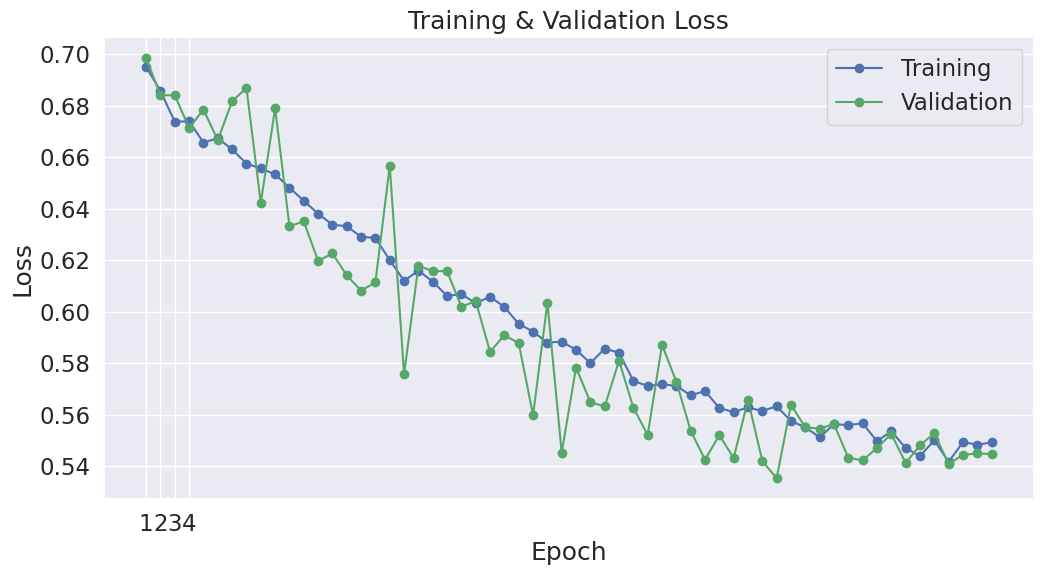

In [33]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

sns.set(style='darkgrid')

sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

### 2.3  Evaluating my fine-tuned model

In [34]:
# Loading the dataset
df = pd.read_csv('in_domain_dev.csv')
print(df.head())

   id                                           sentence  acceptable  \
0   0                            Иван вчера не позвонил.           1   
1   1  У многих туристов, кто посещают Кемер весной, ...           0   
2   2  Лесные запахи набегали волнами; в них смешалос...           1   
3   3  Вчера президент имел неофициальную беседу с ан...           1   
4   4  Коллега так и не признал вину за катастрофу пе...           1   

  error_type detailed_source  
0          0   Paducheva2013  
1     Syntax            USE8  
2          0            USE5  
3          0    Seliverstova  
4          0       Testelets  


In [35]:
import pandas as pd

# Reporting the number of sentences.
print('Number of test sentences: {:,}\n'.format(df.shape[0]))

# Creating sentence and label lists
sentences = df.sentence.values
labels = df.acceptable.values

# Tokenizing all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

for sent in sentences:
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 64,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )

    # Add the encoded sentence to the list.
    input_ids.append(encoded_dict['input_ids'])

    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Set the batch size.
batch_size = 32

# Create the DataLoader.
prediction_data = TensorDataset(input_ids, attention_masks, labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

Number of test sentences: 983



/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2834: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [36]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(input_ids)))

# Put model in evaluation mode
model.eval()

# Tracking variables
predictions , true_labels = [], []

# Predict
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)

  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch

  # Telling the model not to compute or store gradients, saving memory and
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None,
                      attention_mask=b_input_mask)

  logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()

  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 983 test sentences...
    DONE.


In [37]:
print('Positive samples: %d of %d (%.2f%%)' % (df.acceptable.sum(), len(df.acceptable), (df.acceptable.sum() / len(df.acceptable) * 100.0)))

Positive samples: 733 of 983 (74.57%)


In [38]:
from sklearn.metrics import matthews_corrcoef

matthews_set = []

# Evaluating each test batch using Matthew's correlation coefficient
print('Calculating Matthews Corr. Coef. for each batch...')

for i in range(len(true_labels)):

  # The predictions for this batch are a 2-column ndarray (one column for "0"
  # and one column for "1"). Pick the label with the highest value and turn this
  # in to a list of 0s and 1s.
  pred_labels_i = np.argmax(predictions[i], axis=1).flatten()

  # Calculating and store the coef for this batch.
  matthews = matthews_corrcoef(true_labels[i], pred_labels_i)

Calculating Matthews Corr. Coef. for each batch...


In [39]:
# Combine the results across all batches.
flat_predictions = np.concatenate(predictions, axis=0)

# For each sample, pick the label (0 or 1) with the higher score.
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_labels = np.concatenate(true_labels, axis=0)

# Calculate the MCC
mcc = matthews_corrcoef(flat_true_labels, flat_predictions)

print('Total MCC: %.3f' % mcc)

Total MCC: 0.324


In [40]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(flat_true_labels, flat_predictions)
print(f'Accuracy: {accuracy:.3f}')

Accuracy: 0.743


In [41]:
from collections import Counter

print("True label distribution:", Counter(flat_true_labels))
print("Predicted label distribution:", Counter(flat_predictions))


True label distribution: Counter({1: 733, 0: 250})
Predicted label distribution: Counter({1: 730, 0: 253})


In [42]:
from sklearn.metrics import classification_report, confusion_matrix

print("Classification report:\n", classification_report(flat_true_labels, flat_predictions))
print("Confusion matrix:\n", confusion_matrix(flat_true_labels, flat_predictions))


Classification report:
               precision    recall  f1-score   support

           0       0.49      0.50      0.50       250
           1       0.83      0.83      0.83       733

    accuracy                           0.74       983
   macro avg       0.66      0.66      0.66       983
weighted avg       0.74      0.74      0.74       983

Confusion matrix:
 [[125 125]
 [128 605]]



#**Logging with MLflow**

In [43]:
import mlflow

# Creating a new experiment
experiment_name = "LoRA_parameters_Experiment"
mlflow.create_experiment(experiment_name)

mlflow.set_experiment(experiment_name)

# Now start the training and logging
with mlflow.start_run(run_name="LoRA Config Experiment"):
    # Log LoRA configuration parameters
    mlflow.log_param("task_type", "SEQ_CLS")
    mlflow.log_param("inference_mode", False)
    mlflow.log_param("r", 16)
    mlflow.log_param("lora_alpha", 32)
    mlflow.log_param("lora_dropout", 0.2)
    mlflow.log_param("target_modules", ["query", "value"])

    mlflow.log_metric("accuracy", accuracy)  # Accuracy metric
    mlflow.log_metric("total_mcc", mcc)  # MCC metric

    print(f"Logged metrics: Accuracy = {accuracy:.3f}, Total MCC = {mcc:.3f}")


Logged metrics: Accuracy = 0.743, Total MCC = 0.324
